In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../LIFT')

import matplotlib.pyplot as plt
import numpy as np
from warnings import warn
try:
    import torch
except ImportError or ModuleNotFoundError:
    raise ImportError('PyTorch is not installed! Cannot proceed...')

try:
    import cupy as cp
except ImportError or ModuleNotFoundError:
    warn('CuPy is not installed, using NumPy backend...')
    cp = np

from LIFT.modules.Telescope import Telescope 
from LIFT.modules.Detector import Detector
from LIFT.modules.Source import Source
from LIFT.modules.Zernike import Zernike
from LIFT.modules.LIFT import LIFT
from LIFT.tools.misc import mask_circle, optimal_img_size

def npy(x):
    if hasattr(x, 'get'):
        return x.get()
    elif isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    else:
        return x

# Initializing optical system

In [2]:
D = 8.0 # [m]
pixel_size = 24e-6 # [m]
ang_pixel = 12.3 # [mas]
f = pixel_size / ang_pixel * 206264806.71915 # [m]
# Lets imagine we have DITs of 10 frames with tota 1 second exposure
# This is to generate a synthetic PSF 
sampling_time = 0.1 # [s]
num_samples = 10 # Total: 1 second of exposure

pupil_mask = mask_circle(127, 64) - mask_circle(127, 16) # Initialize pupil mask with central obscuration

# If the number of pixels in image is odd, the code will automatically center generated PSFs it to one pixel in the middle

tel = Telescope(img_resolution    = 21, # Will be changed later
                pupil             = pupil_mask,
                diameter          = D,
                focalLength       = f,
                pupilReflectivity = 1.0, # Perfectly reflecting pupil
                gpu_flag          = True)

det = Detector(pixel_size     = pixel_size,
                sampling_time = sampling_time,
                samples       = num_samples,
                RON           = 2.0, # used to generate PSF or the synthetic R_n [photons]
                QE            = 0.7) # currently not used

det.object = None # You can defin a an arbitrary convolution kernel to an object, but we are not doing it here 
det * tel
ngs = Source([('H', 19.5), ('J', 19.5)]) # Initialize a polychromatic target, flux from boths bands adds up
ngs * tel # attach the source to the telescope

N_modes_simulated = 10 # Number of orders to simulate
tel.img_resolution = optimal_img_size(tel, N_modes_simulated, force_odd=True) # Change the the optimal image size required to capture the specified number of modes

# Initialize modal basis
Z_basis = Zernike(modes_num=100)
Z_basis.computeZernike(tel)

astig_shift = 200e-9 #[m]
astig_diversity = Z_basis.Mode(4) * astig_shift

-------------------- TELESCOPE --------------------
Diameter 			8.0 	 [m]
Pupil sampling 			127 	 [pix]
------------------------------------------------


# Generating PSF

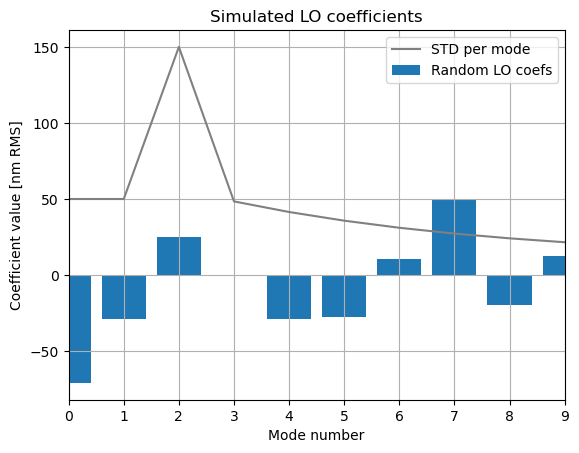

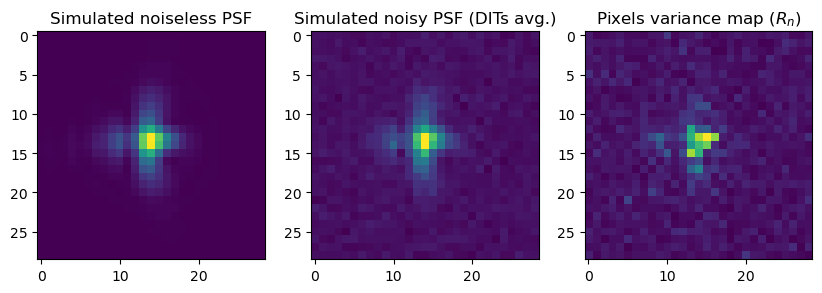

In [6]:
LO_dist_law = lambda x, A, B, C: A / cp.exp(B*cp.abs(x)) + C
x = cp.arange(N_modes_simulated)
LO_distribution = LO_dist_law(x, *[70, 0.2, 10])
LO_distribution[0:2] = 50
LO_distribution[2] = 150
LO_distribution *= 1e-9 # [nm] -> [m]

coefs_LO = cp.random.normal(0, LO_distribution, N_modes_simulated)

plt.title('Simulated LO coefficients')

plt.bar(npy(x), npy(coefs_LO)*1e9, label='Random LO coefs')
plt.plot(npy(x), npy(LO_distribution)*1e9, label='STD per mode', color='gray')

plt.xticks(x.get())
plt.xlim(0, N_modes_simulated-1)
plt.grid()
plt.legend()
plt.ylabel('Coefficient value [nm RMS]')
plt.xlabel('Mode number')
plt.show()

def PSFfromCoefs(coefs, diversity):
    tel.src.OPD = Z_basis.wavefrontFromModes(tel,coefs) + diversity # Don't forget to add the diversity term
    PSF = tel.ComputePSF()
    tel.src.OPD *= 0.0 # zero out just in case
    return PSF

PSF_noiseless = PSFfromCoefs(coefs_LO, astig_diversity)
PSF_noisy_DITs, _ = tel.det.getFrame(PSF_noiseless, noise=True, integrate=False) # Adding noise to the PSF and generating a sequence of frames

PSF_noiseless = npy(PSF_noiseless)

R_n = PSF_noisy_DITs.var(axis=2)    # LIFT flux-weighting matrix
PSF_data = PSF_noisy_DITs.mean(axis=2) # input PSF
PSF_data = cp.array(PSF_data)
R_n = cp.array(R_n)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].set_title('Simulated noiseless PSF')
ax[1].set_title('Simulated noisy PSF (DITs avg.)')
ax[2].set_title(r'Pixels variance map ($R_n$)')
ax[0].imshow(PSF_noiseless)

if hasattr(PSF_data,'device'):
    ax[1].imshow(PSF_data.get())
    ax[2].imshow(R_n.get())
else:
    ax[1].imshow(PSF_data)
    ax[2].imshow(R_n)
plt.show()

# Initializing LIFT

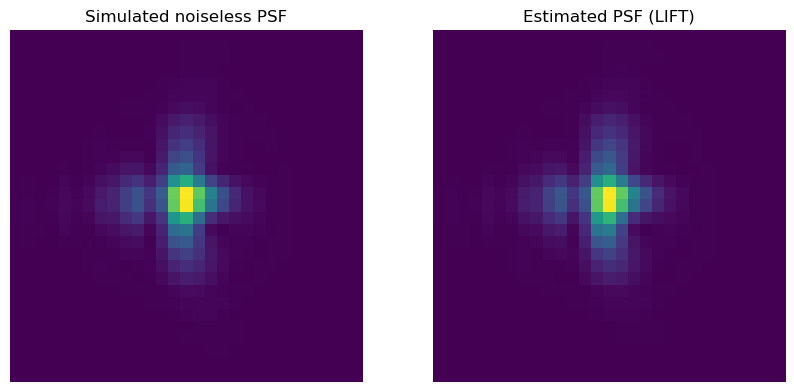

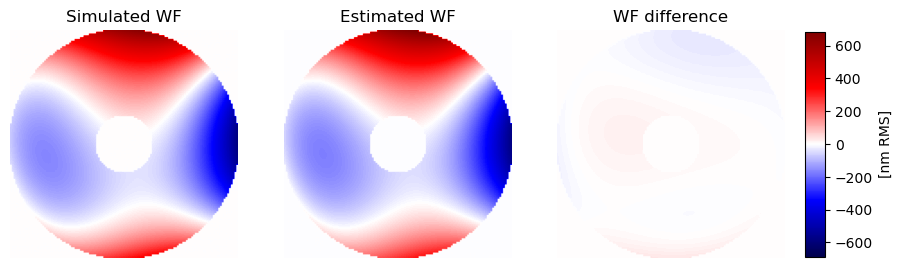

Introduced WF: 199.19, WFE: 11.05 [nm RMS]


In [7]:
estimator = LIFT(tel, Z_basis, astig_diversity, 20)

modes_LIFT = [0,1,2,3,4,5,6,7,8,9,10] # Selected Zernike modal coefficients
# Note! Sometime, for ML-estimation it is better to exlude an order coincding with the diversity term (e.g. 4th order in this case) to reduce the cross coupling between modes

coefs_mean = cp.zeros([max(modes_LIFT)+1]) # Initial guess for the mean value of the modal coefficients (for MAP estimator)
coefs_var  = LO_distribution**2 # Initial guess for the variance of the modal coefficients (for MAP estimator)

coefs_LIFT,  PSF_LIFT, _  = estimator.Reconstruct(PSF_data, R_n=R_n, mode_ids=modes_LIFT, optimize_norm='sum')
    
def GenerateWF(coefs, diversity=0.0):
    return (Z_basis.wavefrontFromModes(tel, coefs) + diversity) * 1e9 # [nm]

calc_WFE = lambda WF: np.std(WF[pupil_mask == 1]) if not hasattr(WF, 'get') else cp.std(WF[pupil_mask == 1])

WF_0    = GenerateWF(coefs_LO,   astig_diversity)
WF_LIFT = GenerateWF(coefs_LIFT, astig_diversity)

if hasattr(WF_0,     'device'): WF_0     = WF_0.get()
if hasattr(WF_LIFT,  'device'): WF_LIFT  = WF_LIFT.get()
if hasattr(PSF_data, 'device'): PSF_data = PSF_data.get()
if hasattr(PSF_LIFT, 'device'): PSF_LIFT = PSF_LIFT.get()

d_WF  = WF_0 - WF_LIFT
d_WFE = calc_WFE(d_WF)
WFE_0 = calc_WFE(WF_0)

c_lim = np.max([np.max(np.abs(WF_0)), np.max(np.abs(WF_LIFT)), np.max(np.abs(d_WF))])

# Compare PSFs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(PSF_noiseless)
ax[0].set_title('Simulated noiseless PSF')
ax[1].imshow(PSF_LIFT)
ax[1].set_title('Estimated PSF (LIFT)')
ax[0].axis('off')
ax[1].axis('off')
plt.show()

# Compare wavefronts
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(WF_0, vmin=-c_lim, vmax=c_lim, cmap='seismic')
ax[0].set_title('Simulated WF')
ax[1].imshow(WF_LIFT, vmin=-c_lim, vmax=c_lim, cmap='seismic')
ax[1].set_title('Estimated WF')
ax[2].imshow(d_WF, vmin=-c_lim, vmax=c_lim, cmap='seismic')
ax[2].set_title('WF difference')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
# Add colorbar
cax = fig.add_axes([0.92, 0.27, 0.02, 0.45])
fig.colorbar(ax[2].imshow(d_WF, vmin=-c_lim, vmax=c_lim, cmap='seismic'), cax=cax)
cax.set_ylabel('[nm RMS]')
plt.show()

print(f'Introduced WF: {WFE_0:.2f}, WFE: {d_WFE:.2f} [nm RMS]')

# DIP example #1: using DIP like LIFT

Stopped at it. 8 with loss: 0.0012785886647179723


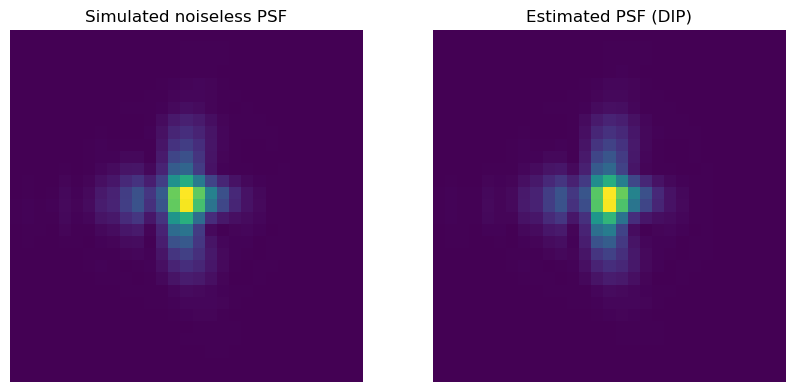

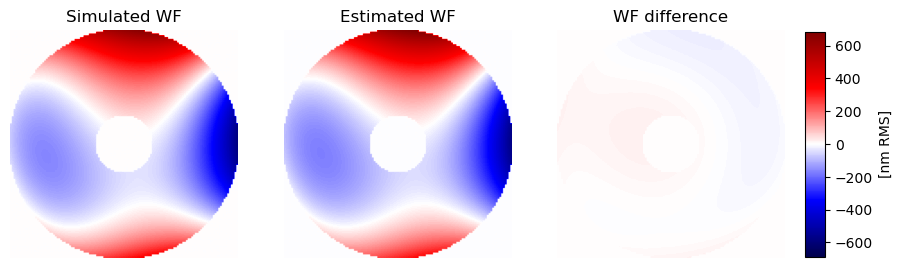

Introduced WF: 199.19, WFE: 10.65 [nm RMS]


In [8]:
from DIP import DIP
from utils import EarlyStopping


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dip = DIP(tel, device, 'sum')
dip.diversity   = torch.atleast_3d(torch.tensor(astig_diversity)*1e9).to(device)
dip.modal_basis = torch.tensor(Z_basis.modesFullRes, dtype=torch.float32, device=device)

PSF_torch = torch.tensor(PSF_data/PSF_data.sum()).float().to(device).unsqueeze(0)

#%%
from scipy.ndimage import median_filter
from torch import nn, optim
inv_R_n_torch = median_filter(1.0 / R_n.get(), 4) + 1.0
inv_R_n_torch = torch.tensor(inv_R_n_torch).float().to(device).unsqueeze(0)

num_modes_DIP = 10

assert num_modes_DIP <= N_modes_simulated, 'Number of modes to estimate is larger than the number of modes simulated'

def coefs2WF(coefs):
    OPD_all = (dip.modal_basis[:,:,:num_modes_DIP] * coefs.view(1,1,-1)).sum(dim=2, keepdim=True) + dip.diversity
    OPD = (OPD_all).permute([2,0,1])
    return OPD

coefs_DIP_defocus = torch.zeros(num_modes_DIP, requires_grad=True, device=device)

loss_fn = nn.MSELoss(reduction='sum')
early_stopping = EarlyStopping(patience=5, tolerance=0.0001, relative=False)
optimizer = optim.LBFGS([coefs_DIP_defocus], history_size=20, max_iter=5, line_search_fn="strong_wolfe")    

def criterion():
    loss = loss_fn( dip(OPD=coefs2WF(coefs_DIP_defocus))*inv_R_n_torch, PSF_torch*inv_R_n_torch)
    return loss # add whatever regularizer you want here
    
verbose = True

for i in range(200):
    optimizer.zero_grad()
    loss = criterion()
    early_stopping(loss)
    loss.backward()
    optimizer.step( lambda: criterion() )
    if verbose: print(f'Loss (iter. {i}/200): {loss.item()}', end='\r')

    if early_stopping.stop:
        if verbose: print('Stopped at it.', i, 'with loss:', loss.item())
        break

with torch.no_grad():       
    PSF_DIP = npy( dip(OPD = (WF_DIP:=coefs2WF(coefs_DIP_defocus))).squeeze() )
    WF_DIP  = npy( WF_DIP.squeeze() )

# Compare PSFs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(PSF_noiseless)
ax[0].set_title('Simulated noiseless PSF')
ax[1].imshow(PSF_DIP)
ax[1].set_title('Estimated PSF (DIP)')
ax[0].axis('off')
ax[1].axis('off')
plt.show()

d_WFE = calc_WFE(d_WF := WF_0-WF_DIP)

# Compare wavefronts
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(WF_0, vmin=-c_lim, vmax=c_lim, cmap='seismic')
ax[0].set_title('Simulated WF')
ax[1].imshow(WF_DIP, vmin=-c_lim, vmax=c_lim, cmap='seismic')
ax[1].set_title('Estimated WF')
ax[2].imshow(d_WF, vmin=-c_lim, vmax=c_lim, cmap='seismic')
ax[2].set_title('WF difference')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
# Add colorbar
cax = fig.add_axes([0.92, 0.27, 0.02, 0.45])
fig.colorbar(ax[2].imshow(d_WF, vmin=-c_lim, vmax=c_lim, cmap='seismic'), cax=cax)
cax.set_ylabel('[nm RMS]')
plt.show()

print(f'Introduced WF: {WFE_0:.2f}, WFE: {d_WFE:.2f} [nm RMS]')

# DIP example #2: phase diversity with defocus and multiple focal planes

(-0.5, 28.5, 28.5, -0.5)

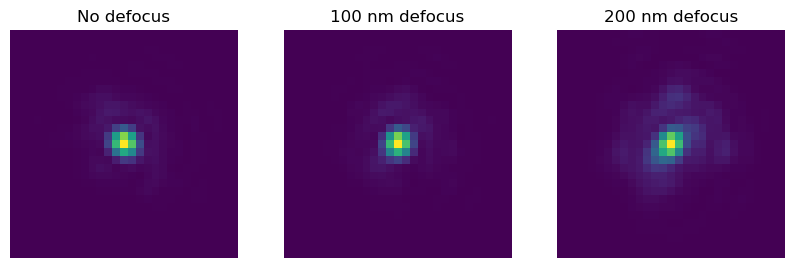

In [10]:
N_modes_simulated = 40

x = cp.arange(N_modes_simulated)

defoc_shift = 200e-9 #[m]
defoc_diversity = Z_basis.Mode(2) * defoc_shift

LO_distribution = LO_dist_law(x, *[70, 0.2, 10])
LO_distribution[0:2] = 50
LO_distribution *= 1e-9 # [nm] -> [m]

coefs_LO = cp.random.normal(0, LO_distribution, N_modes_simulated)

PSF_def_0   = PSFfromCoefs(coefs_LO, defoc_diversity * 0.0)
PSF_def_100 = PSFfromCoefs(coefs_LO, defoc_diversity * 0.5)
PSF_def_200 = PSFfromCoefs(coefs_LO, defoc_diversity)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(npy(PSF_def_0))
ax[0].set_title('No defocus')
ax[1].imshow(npy(PSF_def_100))
ax[1].set_title('100 nm defocus')
ax[2].imshow(npy(PSF_def_200))
ax[2].set_title('200 nm defocus')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

Stopped at it. 9 with loss: 5.2629708079621196e-05


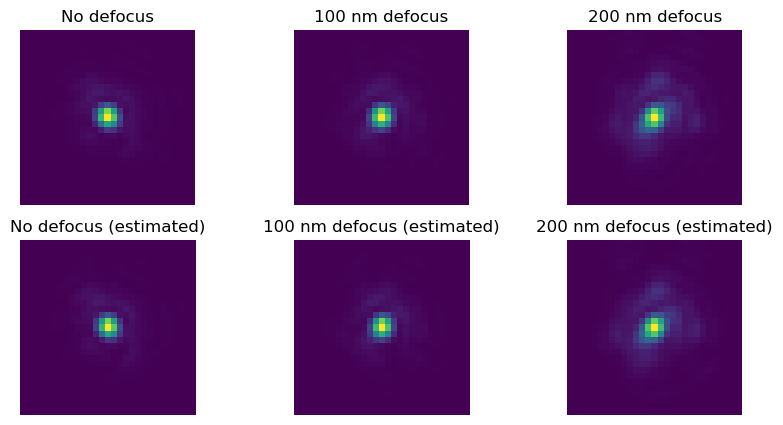

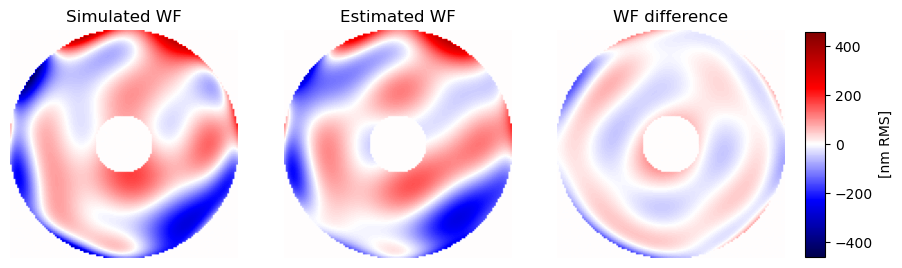

Introduced WF: 199.19, WFE: 32.96 [nm RMS]


In [14]:
PSF_DIP_defocus = np.stack([PSF_def_0, PSF_def_100, PSF_def_200])
PSF_DIP_defocus = torch.tensor(PSF_DIP_defocus).float().to(device)
PSF_DIP_defocus = PSF_DIP_defocus / PSF_DIP_defocus.sum(dim=(1,2), keepdim=True)

num_modes_DIP = 40

coefs_DIP_defocus = torch.zeros(num_modes_DIP, requires_grad=True, device=device)

loss_fn = nn.MSELoss(reduction='sum')
early_stopping = EarlyStopping(patience=5, tolerance=0.0001, relative=False)
optimizer = optim.LBFGS([coefs_DIP_defocus], history_size=20, max_iter=5, line_search_fn="strong_wolfe")    

dip.diversity = torch.atleast_3d(torch.tensor(defoc_diversity)*1e9).to(device)

def coefs2WF(coefs):
    OPD_0 = (dip.modal_basis[:,:,:num_modes_DIP] * coefs.view(1,1,-1)).sum(dim=2, keepdim=True)
    OPD_1 = (dip.modal_basis[:,:,:num_modes_DIP] * coefs.view(1,1,-1)).sum(dim=2, keepdim=True) + dip.diversity * 0.5
    OPD_2 = (dip.modal_basis[:,:,:num_modes_DIP] * coefs.view(1,1,-1)).sum(dim=2, keepdim=True) + dip.diversity
 
    return torch.stack([OPD_0, OPD_1, OPD_2], dim=2).squeeze().permute(2,0,1)
def criterion():
    return loss_fn( dip(OPD=coefs2WF(coefs_DIP_defocus)), PSF_DIP_defocus)

for i in range(200):
    optimizer.zero_grad()
    loss = criterion()
    early_stopping(loss)
    loss.backward()
    optimizer.step( lambda: criterion() )
    if verbose: print(f'Loss (iter. {i}/200): {loss.item()}', end='\r')

    if early_stopping.stop:
        if verbose: print('Stopped at it.', i, 'with loss:', loss.item())
        break

with torch.no_grad():       
    PSF_DIP_defocus = npy( dip(OPD = (WF_DIP_defocus:=coefs2WF(coefs_DIP_defocus))).squeeze() )
    WF_DIP_defocus  = npy( WF_DIP_defocus.squeeze() )
    
fig, ax = plt.subplots(2, 3, figsize=(10, 5))
ax[0,0].imshow(npy(PSF_def_0))
ax[0,0].set_title('No defocus')
ax[0,1].imshow(npy(PSF_def_100))
ax[0,1].set_title('100 nm defocus')
ax[0,2].imshow(npy(PSF_def_200))
ax[0,2].set_title('200 nm defocus')
ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,2].axis('off')

ax[1,0].imshow(npy(PSF_DIP_defocus[0,...]))
ax[1,0].set_title('No defocus (estimated)')
ax[1,1].imshow(npy(PSF_DIP_defocus[1,...]))
ax[1,1].set_title('100 nm defocus (estimated)')
ax[1,2].imshow(npy(PSF_DIP_defocus[2,...]))
ax[1,2].set_title('200 nm defocus (estimated)')
ax[1,0].axis('off')
ax[1,1].axis('off')
ax[1,2].axis('off')


WF_nodefocus   = npy( GenerateWF(coefs_LO)  )
WF_estim_nodef = npy( WF_DIP_defocus[0,...] )

c_lim = np.max([np.max(np.abs(WF_nodefocus)), np.max(np.abs(WF_estim_nodef))])

d_WFE = calc_WFE(d_WF:=WF_nodefocus-WF_estim_nodef)

# Compare wavefronts
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(WF_nodefocus, vmin=-c_lim, vmax=c_lim, cmap='seismic')
ax[0].set_title('Simulated WF')
ax[1].imshow(WF_estim_nodef, vmin=-c_lim, vmax=c_lim, cmap='seismic')
ax[1].set_title('Estimated WF')
ax[2].imshow(d_WF, vmin=-c_lim, vmax=c_lim, cmap='seismic')
ax[2].set_title('WF difference')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
# Add colorbar
cax = fig.add_axes([0.92, 0.27, 0.02, 0.45])
fig.colorbar(ax[2].imshow(d_WF, vmin=-c_lim, vmax=c_lim, cmap='seismic'), cax=cax)
cax.set_ylabel('[nm RMS]')
plt.show()

print(f'Introduced WF: {WFE_0:.2f}, WFE: {d_WFE:.2f} [nm RMS]')